# 第3章　scikit-learn机器学习分类器

本章将介绍学术界和行业中常用且强大的一系列机器学习算法。了解几个监督学习分类算法之间的差异，培养鉴别算法优劣的直觉。此外，scikit-learn软件库为高效且富有成果地使用这些算法提供了友好且统一的用户界面，本章将从该软件库开始。

本章将主要涵盖下述几个方面：

- 介绍强大且常用的分类算法，如逻辑回归、支持向量机和决策树。
- scikit-learn机器学习库通过对用户友好的Python API提供各种机器学习算法，本章将通过示例对其进行解释。
- 比较线性和非线性决策边界分类器的优劣。

# 3.1　选择分类算法

每种算法都是基于某些假设的而且都有各自的特点，为特定问题选择合适的分类算法需要实践经验。David·H. Wolpert提出的天下没有免费午餐的定理，明确说明不存在适合所有可能场景的分类算法^[The Lack of A Priori Distinctions Between Learning Algorithms, Wolpert, David H, Neural Computation 8.7 (1996): 1341-1390.]。在实践中，因为样本特征的数量、数据中的噪声以及是否线性可分等各种情况有所不同，所以我们建议至少要比较几种不同学习算法的性能，以选择适合特定问题的最佳模型。

分类器的计算性能以及预测能力，最终在很大程度上取决于可供学习的基础数据。可以把监督机器学习算法训练的五个主要步骤概括如下：

1. 选择特征并收集已标注的训练样本。
2. 选择性能度量指标。
3. 选择分类器并优化算法。
4. 评估模型的性能。
5. 算法调优。

本书所采用的方法是逐步构建机器学习知识，本章将主要聚焦在不同算法的主要概念上面，并回顾诸如特征选择、预处理、性能指标和超参数调优等主题，我们将在本书的后半部分对此进行更为详细的讨论。

# 3.2　了解scikit-learn的第一步——训练感知器

在第2章中，我们学习了感知器规则和Adaline两个机器学习分类算法，并亲手用Python和NumPy实现了代码。现在我们来看一下scikit-learn的API，如前所述，它结合了对用户友好的界面和高度优化的几种分类算法。scikit-learn软件库不仅提供了大量的学习算法，同时也包含了预处理数据、微调和评估模型等许多方便的功能。在第4章和第5章中，我们将对此及其他基本概念进行更详细的讨论。

作为理解scikit-learn软件库的起点，本章将训练类似在第2章中实现的那种感知器。为了简单起见，本书将在以后章节中继续使用已经熟悉的鸢尾花数据集。这么做很方便，因为该数据集简单且常见，经常被用于测试和检验算法，况且我们已经在前面使用scikit-learn软件库的过程中获得了该数据集。下面将用鸢尾花数据集的两个特征来实现可视化。

我们将把150个鸢尾花样本的花瓣长度和宽度存入特征矩阵X，把相应的品种分类标签存入向量y：

In [1]:
from sklearn import datasets
import numpy as np

In [2]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels: ', np.unique(y))

Class labels:  [0 1 2]


为了评估经过训练的模型对未知数据处理的效果，我们再进一步将数据集分割成单独的训练数据集和测试数据集：

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

利用scikit-learn库`model_selection`模块的`train_test_split`函数，把X和y数组随机拆分为30%的测试数据集（45个样本）和70%的训练数据集（105个样本）。

请注意，`train_test_split`函数在分割数据集之前已经在内部对训练数据集进行了洗牌，否则，所有分类标签为0和1的样本都会被分到训练数据集，所有分类标签为2的45份样本数据都将被分到测试数据集。通过设置`random_state`参数，我们将为内部的伪随机数生成器提供一个固定的随机种子（`random_state=1`），该生成器用于在分割数据集之前进行洗牌。采用这样固定的`random_state`可以确保结果可重现。

最后，我们通过定义`stratify=y`获得内置的分层支持。这种分层意味着调用`train_test_split`方法可以返回与输入数据集的分类标签相同比例的训练数据集和测试数据集。可以调用NumPy的`bincount`函数统计数组中每个值出现数，以验证数据：

In [4]:
print('Labels counts in y: ', np.bincount(y))

Labels counts in y:  [50 50 50]


In [5]:
print('Labels counts in y_train: ', np.bincount(y_train))

Labels counts in y_train:  [35 35 35]


In [6]:
print('Labels counts in y_test: ', np.bincount(y_test))

Labels counts in y_test:  [15 15 15]


许多机器学习和优化算法也需要进行特征缩放以获得最佳性能，正如在第2章的梯度下降示例中所看到的那样。在这里，使用`scikit-learn`的`preprocessing`模块的`StandardScaler`类来标准化特征：

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

利用前面的代码，我们可以加载`preprocessing`模块中的`StandardScaler`类，初始化一个新的`StandardScaler`对象，然后将其分配给变量sc。调用`StandardScaler`的`fit`方法对训练数据的每个特征维度估计参数$μ$（样本均值）和$σ$（标准差）进行估算。然后再调用`transform`方法，利用估计的参数$μ$和$σ$标准化训练数据。在标准化测试数据集时，要注意使用相同的缩放参数以确保训练数据集与测试数据集的数值具有可比性。

完成训练数据的标准化之后，我们可以动手训练感知器模型。通过调用**一对其余**（**one-vs.-rest, OvR**）方法，scikit-learn中的大多数算法都默认支持多类分类，允许把三类花的数据同时提交给感知器。具体的代码实现如下：

In [8]:
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

`scikit-learn`接口会让我们想起第2章中的感知器实现：从`linear_model`模块加载`Perceptron`类之后，初始化新的`Perceptron`对象，然后调用fit方法对模型进行训练。在这里，模型参数`eta0`相当于前面感知器实现中用到的学习速率`eta`，`n_iter`参数定义了遍历训练数据集的迭代次数。

记得在第2章中讨论过，要找到合适的学习速率需要一些试验。学习速率过大，算法会错过全局的最小代价点。学习速率过小，算法需要经过太多的迭代才会收敛，降低了学习速度，这对大型数据集的影响尤为明显。同时，我们在每次迭代后，对训练数据集用`random_state`参数进行洗牌，以确保初始结果可以重现。

用`scikit-learn`训练完模型后，我们可以调用`predit`方法做预测，就像在第2章中感知器实现那样，具体代码如下：

In [9]:
y_pred = ppn.predict(X_test_std)
print('Misclassified: %d' % (y_test != y_pred).sum())

Misclassified: 1


执行代码后，可以看到感知器在处理45个花朵样本时出现过1次错误分类。因此，测试数据集上的分类错误率大约为0.022或2.2%（1/45≈0.022）。

`scikit-learn`也实现了许多不同的性能指标，我们可以通过`metrics`模块来调用。例如，可以计算测试数据集上感知器的分类准确率如下：

In [10]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.978


这里`y_test`是真分类标签，而`y_pred`是先前预测的分类标签。另外，每个scikit-learn分类器都有一个评分方法，可以通过综合调用`predict`和`accuracy_score`计算出分类器的预测准确率：

In [11]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.978


最后，可以利用第2章中的plot_decision_regions函数绘制新训练的感知器模型的决策区，并以可视化的方式展示区分不同花朵样本的效果。但是，略加修改通过圆圈来突出显示来自测试数据集的样本：

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # ravel()：数组扁平化处理，将多维数组转换为一维数组
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,              # 透明度：0-完全透明，1-完全不透明
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,               # 设置图列标签
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100,
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidths=1,
                        marker='o',
                        s=100,
                        label='test set')

通过小幅修改plot_decision_regions函数，我们可以在结果图上定义样本的标记索引。代码如下：

C:\Users\LangLang\AppData\Local\Temp\ipykernel_6272\2293761137.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\LangLang\AppData\Local\Temp\ipykernel_6272\2293761137.py:40: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


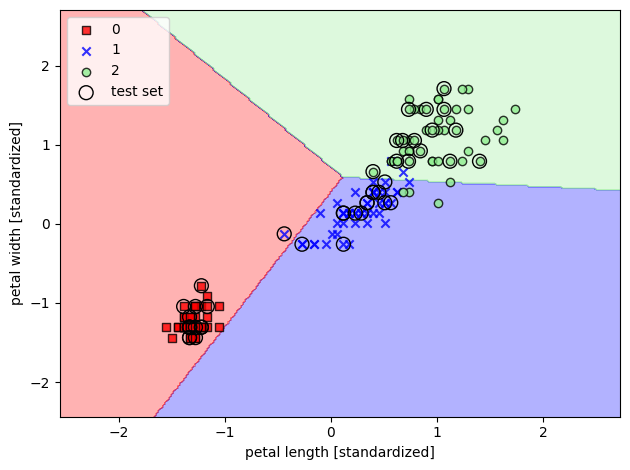

In [13]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

正如从结果图上所看到的那样，三类花不能被线性决策边界完全分离。

sigmoid函数可视化：

In [14]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

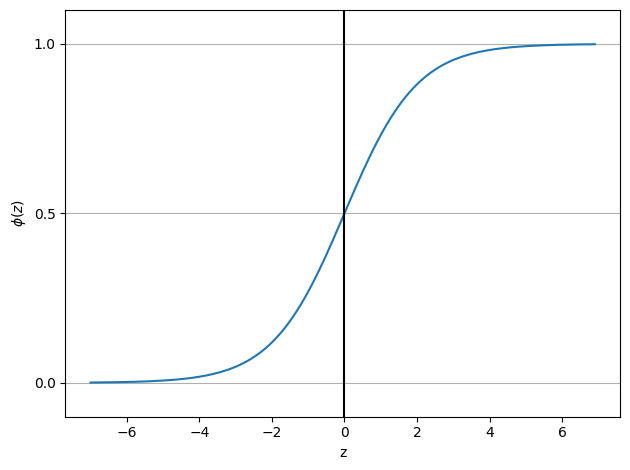

In [15]:
z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
# 在圆点处（x坐标值为0）绘制一条垂直线，颜色为黑色（k）
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])   # 设置y轴刻度值
ax = plt.gca()  # 获取当前坐标轴对象（图形和坐标轴）
ax.yaxis.grid(True)   # 在y轴上添加网格线
plt.tight_layout()  # 调整图形布局，使其紧凑排列，避免重叠和空白区域过大
plt.show()

逻辑回归模型中，单个训练样本的代价随激活函数（sigmoid）的变化：

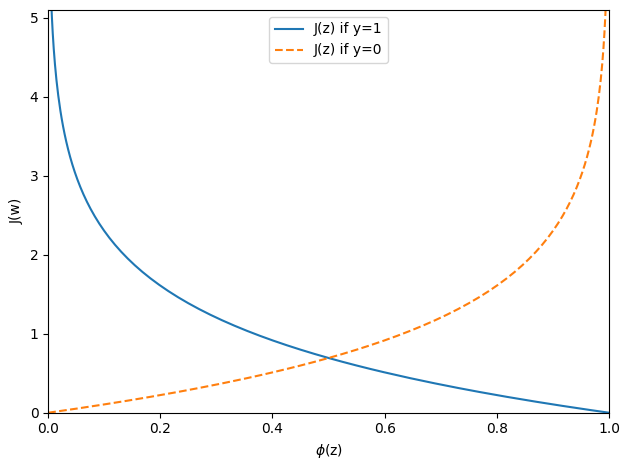

In [16]:
def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(z) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(z) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim(0, 1)
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

## 将Adaline实现转换为一个逻辑回归算法

In [17]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        Random number generator seed for random weight initialization.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Logistic cost function value in each epoch.

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of
            examples and n_features is the number of features.
        y : array-like, shape = [n_examples]
            Target values.

        Returns
        -------
        self : object
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])

        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()

            # note that we compute the logistic 'cost' now
            # instead of the sum of squared errors cost.
            cost = (-y.dot(np.log(output))) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0, 1, 0)
        # equivalent to：
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

当拟合逻辑回归模型时，必须记住该模型只适用于二元分类。所以，只考虑Iris-setosa和Iris-versicolor两种花（类0和类1），并验证逻辑回归的有效性：

C:\Users\LangLang\AppData\Local\Temp\ipykernel_6272\2293761137.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


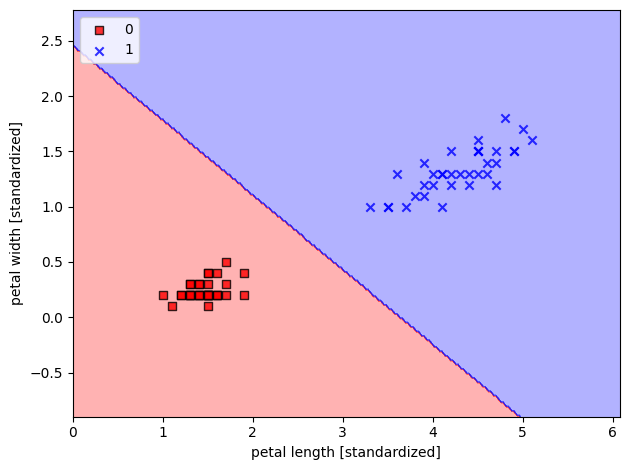

In [18]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 用scikit-learn训练逻辑回归模型
现在来学习如何用scikit-learn或者更优化的逻辑回归来实现，我们也默认支持多元分类的场景。请注意，在scikit-learn的新版中，将会自动选择多元分类、多项式或者OvR技术。我们将在下面的代码示例中用sklearn.linear_model.LogisticRegression类以及熟悉的fit方法，在三种花的标准化训练数据集上训练模型。同时，为了方便解释，我们将设置multi_class='ovr'。读者可能想与把参数定义为multi_class='multinomial'的结果进行对比。请注意，multinomial设置通常推荐用于排他性分类，比如鸢尾花数据集中出现的那些。在这里，“排他”意味着每个训练样本只能属于某类（多元分类的训练样本可以属于多个类）。

现在，让我们看看下面的示例代码：

C:\Users\LangLang\AppData\Local\Temp\ipykernel_6272\2293761137.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\LangLang\AppData\Local\Temp\ipykernel_6272\2293761137.py:40: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


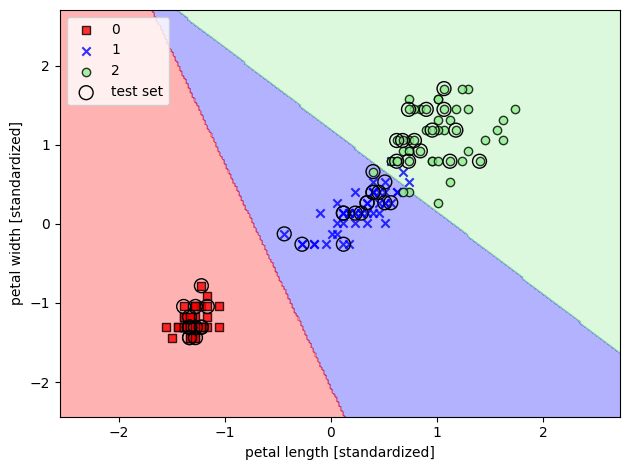

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1,
                        solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

可以用predict_proba计算训练数据集中某个样本属于某个特定类的概率。例如，可以用如下方法预测测试数据集中前三类的概率：

In [20]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

第一行对应属于第一种花的概率，第二行对应属于第二种花的概率，以此类推。注意，所有列数据之和为1（可以通过执行lr.predict_proba（X_test_std［:3,:］）.sum（axis=1）来确认）：

In [21]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

第一行的最大值约为0.85，这意味着第一个样本属于第三种花（Iris-virginica）的预测概率为85%。你可能已经注意到，我们可以通过识别每行中最大列的值得到预测的分类标签，例如可以用NumPy的argmax函数实现：

In [22]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0], dtype=int64)

在前面的代码示例中，我们计算了条件概率，并用NumPy的argmax函数将其手动转换为分类标签。实际上，在用scikit-learn时，获得分类标签更方便的方法是直接调用predict方法：

In [23]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

最后提醒一句，如果想单独预测花样本的分类标签：sciki-learn期望输入一个二维数组，因此，必须先把单行转换成这种格式。调用NumPy的reshape方法增加一个新维度可以将一行数据转换成为二维数组。比如，预测第一个样本的花的分类标签：

In [24]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### 3.3.5　通过正则化解决过拟合问题
过拟合是机器学习中的常见问题，虽然模型在训练数据上表现良好，但不能很好地泛化未见过的新数据或测试数据。如果某个模型出现了过拟合问题，我们会说该模型有高方差，这有可能是因为相对于给定的数据，参数太多，从而导致模型过于复杂。同样，模型也可能会出现欠拟合（高偏差）的情况，这意味着模型不足以捕捉训练数据中的复杂模式，因此对未知数据表现不佳。

虽然迄今我们只遇到过线性分类模型，但是比较线性决策边界和更复杂的非线性决策边界，是解释过拟合与欠拟合问题的最好方法，如下图所示。

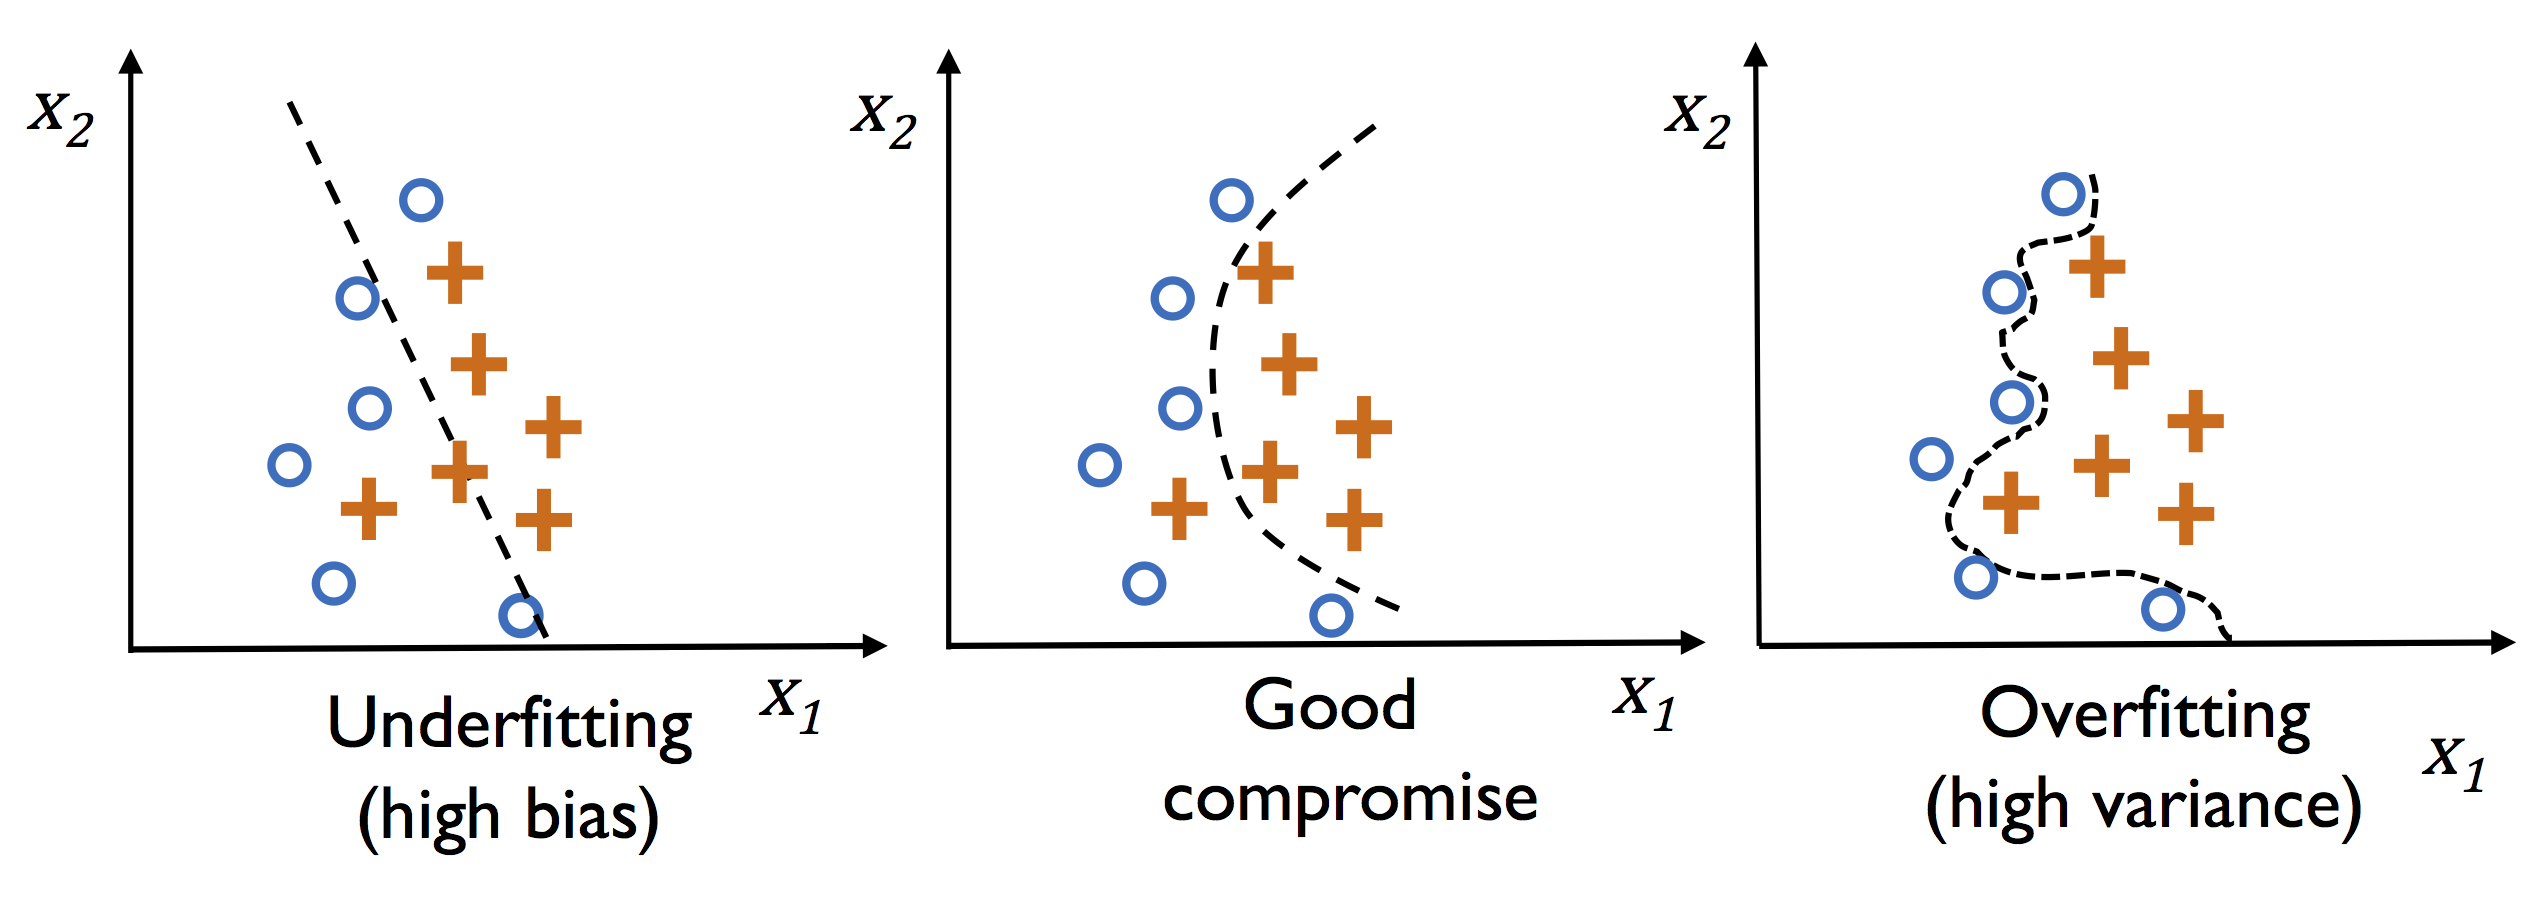

In [25]:
from IPython.display import Image
Image('images/03_07.png', width=500)

### 偏差-方差权衡（The bias-variance tradeoff）
研究人员经常用术语“偏置”和“方差”或“偏置-方差权衡”来描述模型的性能，也就是说，你可能偶然会在谈话、书籍或文章中发现人们提到模型具有“高方差”或“高偏置”。那么，这是什么意思？一般来说，我们可以说“高方差”与过拟合成正比，“高偏置”与欠拟合成正比。


在机器学习模型的场景中，如果我们多次重复训练一个模型，例如在训练数据集的不同子集上，方差可以用于测量模型对特定样本进行分类时预测结果的一致性（或可变性）。可以说，模型对训练数据中的随机性很敏感。相比之下，偏置测量的是，假如在不同的训练数据集上反复建模，预测值离正确值有多远；偏置测量的是非随机性引起的系统误差。

找到一个好的偏置-方差权衡的方法是通过正则化来调整模型的复杂性。正则化是处理共线性（特征间的高相关性）、滤除数据中的噪声并最终防止过拟合的一种非常有用的方法。正则化背后的逻辑是引入额外的信息（偏置）来惩罚极端的参数值（权重）。最常见的正则化是所谓的L2正则化（有时也称为L2收缩或权重衰减）:
$$\frac{\lambda}{2}\left\| w \right\|^2 = \frac{\lambda}{2}\sum\limits_{j=1}^{m}{w_j^2}$$
这里λ为所谓的正则化参数。

### 正则化与特征归一化（Regularization and feature normalization）
特征缩放（如标准化）之所以重要，其中一个原因就是正则化。为了使得正则化起作用，需要确保所有特征的衡量标准保持统一。

通过增加一个简单的正则项，就可以正则化逻辑回归的代价函数，这将在模型训练的过程中缩小权重：
$$J(w) = \sum\limits_{i=0}^{n}[-y^{(i)}log(\phi{(z^{(i)}}))-(1-y^{(i)})log(1-\phi{(z^{(i)})})]+\frac{\lambda}{2}\left\|w\right\|^2$$
通过正则化参数λ，保持权重较小时，我们可以控制模型与训练数据的拟合程度。加大λ值可以增强正则化的强度。

scikit-learn实现LogisticRegression类的参数C来自下一节要介绍的支持向量机中的约定。C是正则化参数λ的倒数，与λ直接相关。因此，减小逆正则化参数C意味着增加正则化的强度，这可以通过绘制对两个权重系数进行L2正则化后的图像予以展示：

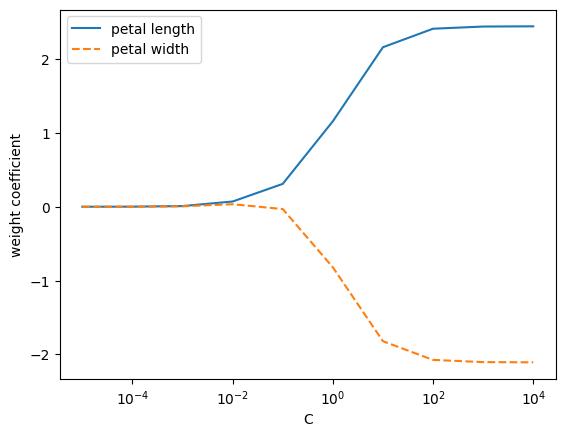

In [26]:
weights, params = [], []
for c in range(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1, 
                            solver='lbfgs', multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.xlabel('C')
plt.ylabel('weight coefficient')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

我们用不同的逆正则化参数C值拟合10个逻辑回归模型。为了方便讲解，我们只收集分类标签为1的权重系数（这里对应数据集中的第2类，即Iris-versicolor）而不是所有类，记住我们使用OvR技术进行多元分类。

如上图所示，如果减小参数C，即增加正则化的强度，那么权重系数会缩小。

## 3.4　使用支持向量机最大化分类间隔
另外一种强大而且广泛应用的机器学习算法是支持向量机（SVM），它可以看作感知器的扩展。感知器算法的目标是最小化分类误差。而支持向量机算法的优化目标是最大化的分类间隔。此处间隔定义为可分离的超平面（决策边界）与其最近的训练样本之间的距离，而最靠近超平面的训练样本称为支持向量，如下图所示：

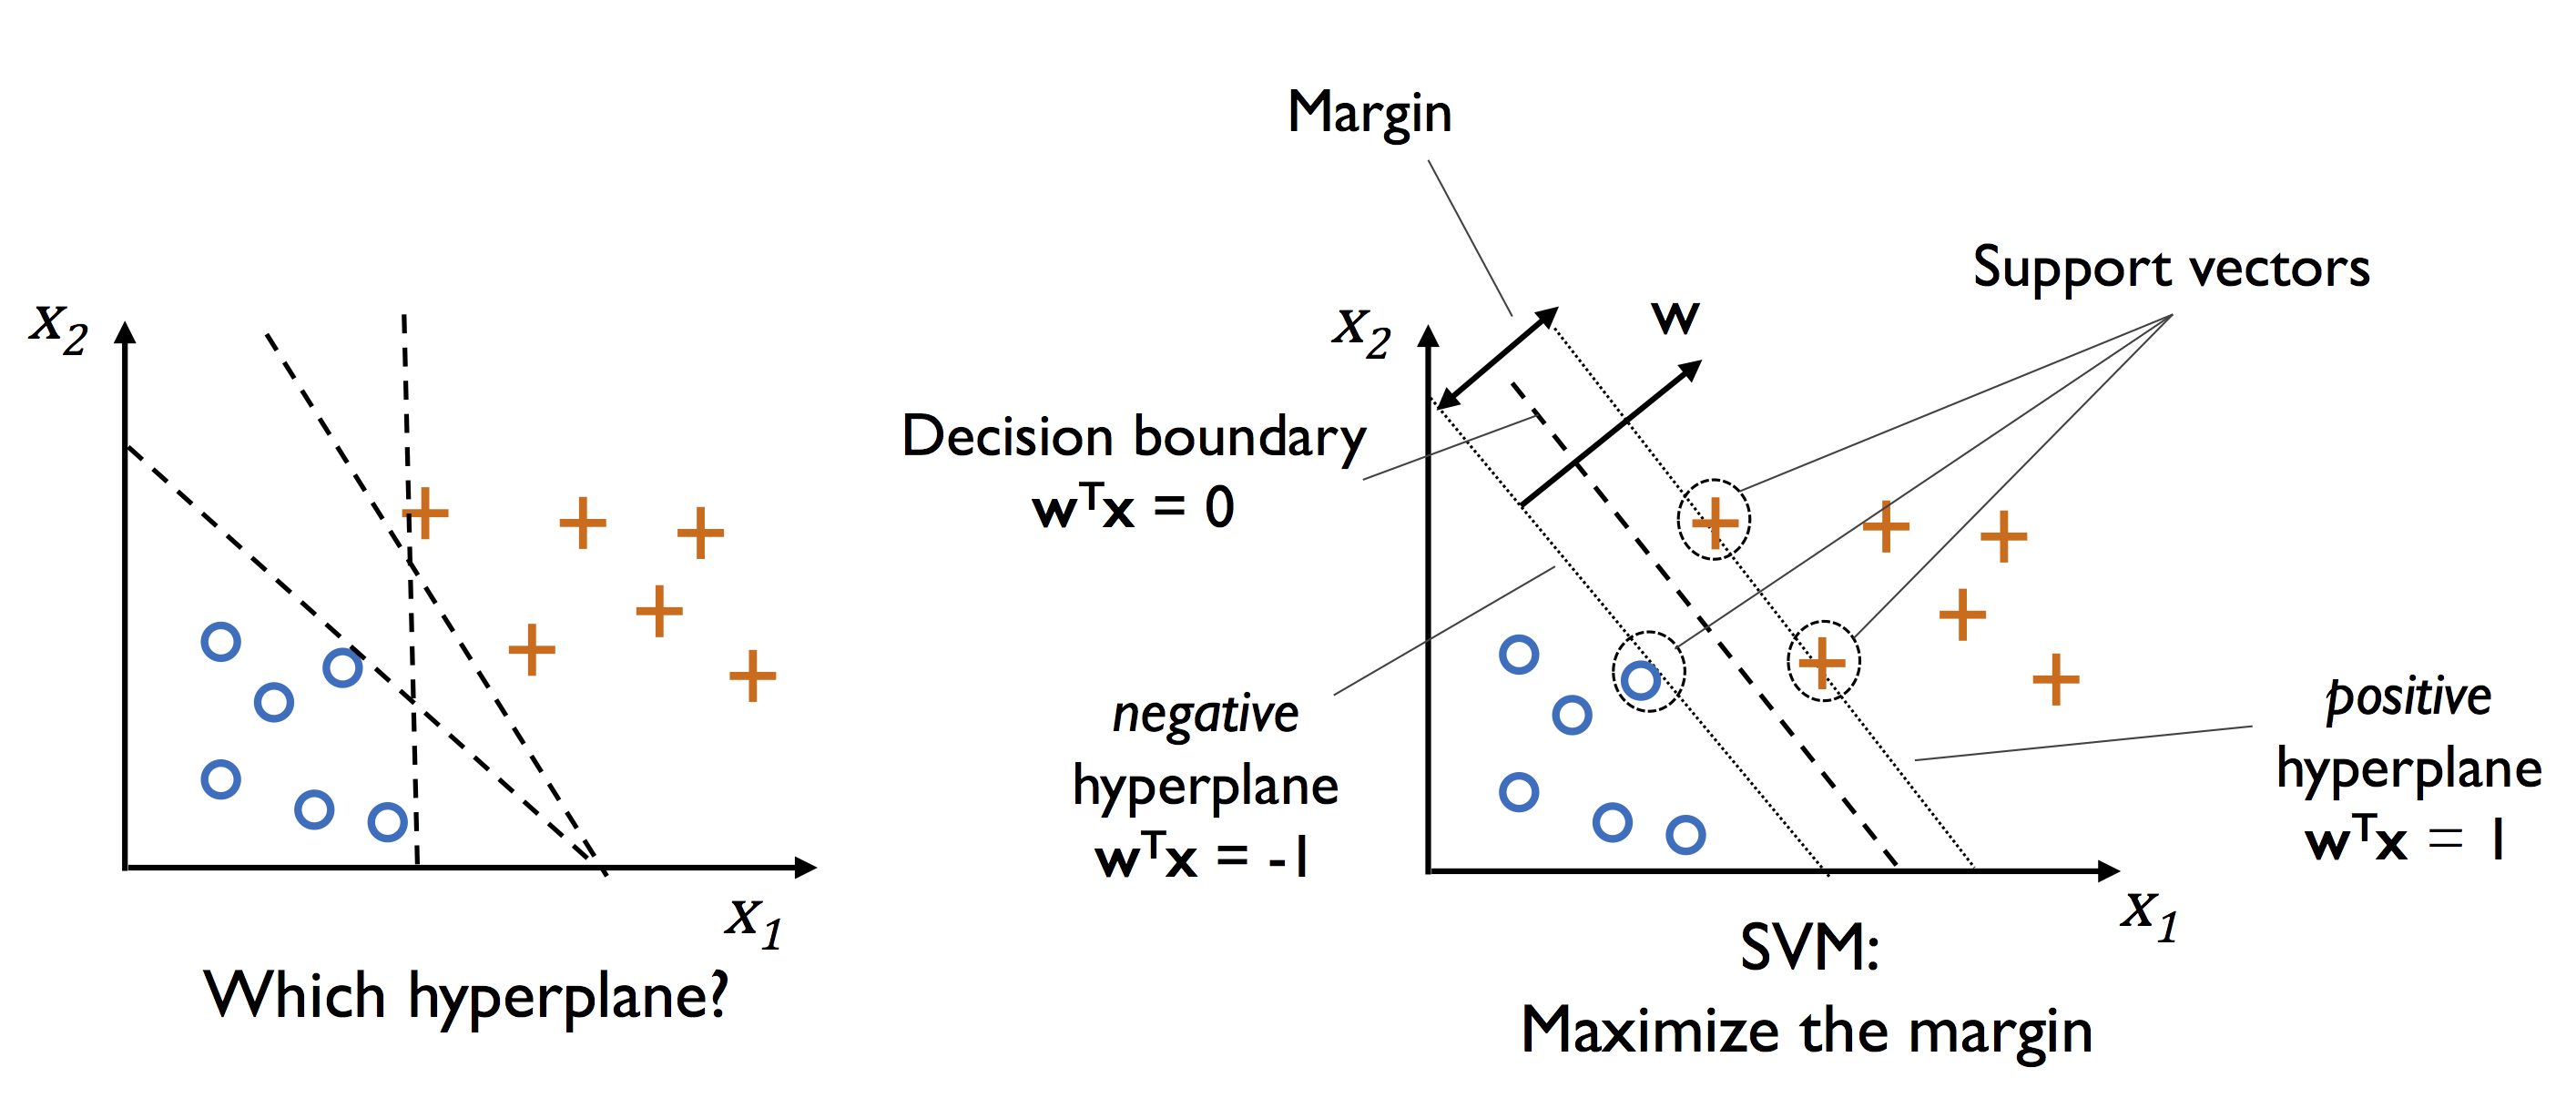

In [29]:
Image('images/03_09.png', width=800)

### 3.4.1　对分类间隔最大化的直观认识
该模型的原理是决策边界间隔较大往往会产生较低的泛化误差，而间隔较小的模型则更容易产生过拟合。为了更好地解释间隔最大化的概念，让我们仔细看看那些与决策边界平行的正超平面和负超平面，表示如下：
$$w_0+w^Tx_{pos} = 1 \tag{1}$$
$$w_0+w^Tx_{neg} = -1 \tag{2}$$
上述两个线性等式（1）和（2）相减可以得到：
$$\implies w^T(x_{pos}-x_{neg}) = 2$$
可以通过求解向量w的长度来规范化该方程，具体计算如下：
$$\begin{Vmatrix}w\end{Vmatrix} = \sqrt{\sum\limits_{j=1}^{m}w_j^2}$$
因此得到以下的结果：
$$\frac{w^T(x_{pos}-x_{neg})}{\begin{Vmatrix}w\end{Vmatrix}} = \frac{2}{\begin{Vmatrix}w\end{Vmatrix}}$$
在样本分类正确的条件约束下，最大化分类间隔也就是使$\frac{2}{\begin{Vmatrix}w\end{Vmatrix}}$最大化，这也是支持向量机的目标函数可以将其表示为：
$$w_0+w^Tx^{(i)}\geq{1} \quad if\space y^{(i)}=1$$
$$w_0+w^Tx^{(i)}\leq{-1} \quad if\space y^{(i)}=-1$$
$$for i = 1\dots N$$
这里N为数据集的样本总数。

这两个方程可以解释为：所有的负类样本基本上都落在负超平面一侧，而所有的正类样本都落在正超平面一侧，我们可以用更为紧凑的方式表达如下：
$$y^{(i)}(w_0+w^Tx^{(i)})\geq{1} \quad \forall_i$$
实际上，计算最小化$\frac{1}{2}\begin{Vmatrix}w\end{Vmatrix}^2$的倒数更为容易，这可以通过二次规划的方法实现。

### 3.4.2　用松弛变量解决非线性可分问题
尽管我们不想对最大间隔分类背后更复杂的数学概念进行讨论，但还是要简要地提一下由Vladimir Vapnik于1995年提出的松弛变量ξ，它引出了所谓的软间隔分类。引入松弛变量ξ的目的是对于非线性可分数据来说，需要放松线性约束，以允许在分类错误存在的情况下通过适当代价的惩罚来确保优化可以收敛。

我们可以直接把取值为正的松弛变量加入线性约束：